In [1]:
%matplotlib inline
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- ATLAS style ---
ROOT.gROOT.LoadMacro("/home/kalelc/research/atlasstyle/AtlasStyle.C")
ROOT.gROOT.LoadMacro("/home/kalelc/research/atlasstyle/AtlasUtils.C")
ROOT.gROOT.LoadMacro("/home/kalelc/research/atlasstyle/AtlasLabels.C")
ROOT.SetAtlasStyle()

ROOT.EnableImplicitMT()

# --- Load Delphes ---
delphes_dir = "/home/kalelc/research/Delphes-3.5.0/"
status = ROOT.gSystem.Load(delphes_dir + "libDelphes.so")
if status != 0:
    raise RuntimeError("Error: Could not load libDelphes.so")
print("libDelphes.so loaded successfully!")

# Input ROOT file
fdir = delphes_dir + "displacedPhoton/prompt_half_dark_events.root"
df = ROOT.RDataFrame("Delphes", fdir)

PHI_FINAL_STATUS = 62
FINAL_STATUS = 1
DPHOTON_PID = 4900022
PHOTON_PID = 22
PHI_PID = 54

EVENT_FILTER = 1000


Applying ATLAS style settings...

libDelphes.so loaded successfully!


In [2]:
# Create the RDataFrame
df = ROOT.RDataFrame("Delphes", fdir)

# Filter out events that have no photons to prevent errors
df = df.Filter("Photon_size > 0", "Events with at least one photon")

df = df.AsNumpy([
    "Event.Number",
    "Photon_size", "Photon.PT", "Photon.Eta", "Photon.Phi", 
    "Jet_size", "Jet.PT", "Jet.Eta", "Jet.Phi", "Jet.Mass",
    "MissingET.MET", "MissingET.Phi",
    "GenMissingET.MET", "GenMissingET.Eta", "GenMissingET.Phi"
    ]) # Add all relevant Branches

df = pd.DataFrame({
    "event": [arr[0] for arr in df["Event.Number"]],
    "photon_size": [arr for arr in df["Photon_size"]],
    "photon_pt": [arr for arr in df["Photon.PT"]],
    "photon_eta": [arr for arr in df["Photon.Eta"]],
    "photon_phi": [arr for arr in df["Photon.Phi"]],
    "met": [arr[0] for arr in df["MissingET.MET"]],
    "met_phi": [arr[0] for arr in df["MissingET.Phi"]],
    "genmet": [arr[0] for arr in df["GenMissingET.MET"]],
    "genmet_eta": [arr[0] for arr in df["GenMissingET.Eta"]],
    "genmet_phi": [arr[0] for arr in df["GenMissingET.Phi"]],
})

df = df[df["event"] < EVENT_FILTER]

# Sort the dataframe by the 'event' column and set it as the index
df = df.sort_values(by="event")

df = df.explode([
    "photon_pt", "photon_eta", "photon_phi",
], ignore_index=True)

df.head(4)

,event,photon_size,photon_pt,photon_eta,photon_phi,met,met_phi,genmet,genmet_eta,genmet_phi
0,0,1,38.24575,1.586421,-0.336175,38.193195,-1.335756,39.143513,0.179296,-1.479393
1,1,1,57.159962,0.326268,-0.548867,21.571005,-2.194716,23.687180,1.921988,-1.932783
2,2,1,46.879234,-0.249339,-2.934141,90.675583,-0.418172,95.386909,0.988994,-0.467594
3,3,2,57.284534,0.321744,-0.541536,82.190346,2.799991,78.944168,2.318977,2.877817


In [3]:
# --- Convert truth particles to pandas ---
particle_df = ROOT.RDataFrame("Delphes", fdir)
particle_dict = particle_df.AsNumpy([
    "Event.Number",
    "Particle.PT",
    "Particle.Phi",
    "Particle.Eta",
    "Particle.PID",
    "Particle.fUniqueID",
    "Particle.D1",
    "Particle.D2",
    "Particle.Status",
])

# Flatten event numbers (scalars, not 1-element arrays)
event_numbers = [arr[0] for arr in particle_dict["Event.Number"]]

# Add particle indices per event (needed for mother/daughter lookup)
particle_dict["Particle.Index"] = [
    np.arange(len(pt)) for pt in particle_dict["Particle.PT"]
]

# Build DataFrame
particle_df = pd.DataFrame({
    "event": event_numbers,
    "ParticleIndex": particle_dict["Particle.Index"],
    "PT": particle_dict["Particle.PT"],
    "Phi": particle_dict["Particle.Phi"],
    "Eta": particle_dict["Particle.Eta"],
    "PID": particle_dict["Particle.PID"],
    "UniqueID": particle_dict["Particle.fUniqueID"],  # keep for reference
    "D1": particle_dict["Particle.D1"],
    "D2": particle_dict["Particle.D2"],
    "Status": particle_dict["Particle.Status"],
})

# Filters
particle_df = particle_df[(particle_df["event"] < EVENT_FILTER)]

# Explode so each particle gets its own row
particle_df = particle_df.explode([
    "ParticleIndex", "PT", "Phi", "Eta", "PID", "UniqueID",
    "D1", "D2", "Status"
], ignore_index=True)

# Convert indices to integer
particle_df[["ParticleIndex", "D1", "D2"]] = particle_df[["ParticleIndex", "D1", "D2"]].astype(int)

particle_df = particle_df.sort_values(by="event").reset_index(drop=True)

particle_df.head(4)

,event,ParticleIndex,PT,Phi,Eta,PID,UniqueID,D1,D2,Status
0,0,47,2.635146,1.59539,-3.160894,21,47,413,413,43
1,0,46,0.0,1.325818,-999.900024,1,46,48,48,42
2,0,77,0.0,-1.815775,999.900024,21,76,79,79,53
3,0,95,1.750638,3.134122,2.198965,21,94,181,209,71


In [4]:
def phi_daughter(row, phi_df):
    """Check if a particle is a daughter of a phi

    Args:
        row (pd.Series): The particle row to check.
        phi_df (pd.DataFrame): The DataFrame containing phi candidates.

    Raises:
        ValueError: If no phi is found for the event.

    Returns:
        bool: True if the particle is a daughter of a phi, False otherwise.
    """
    event = row["event"]
    phis = phi_df[phi_df["event"] == event]
    if phis.empty:
        raise ValueError(f"No phi found for event {event}")
    if row["ParticleIndex"] in phis["D1"].values or row["ParticleIndex"] in phis["D2"].values:
        return True
    else:
        return False

In [5]:
phi_df = particle_df[
    (particle_df["PID"] == PHI_PID) & (particle_df["Status"] == PHI_FINAL_STATUS)
]
phi_df.head(2)

,event,ParticleIndex,PT,Phi,Eta,PID,UniqueID,D1,D2,Status
819,0,904,39.143513,-1.479393,0.179296,54,905,907,908,62
820,0,903,17.414043,1.257855,4.052361,54,904,905,906,62


In [6]:
particle_df["phi_daughter"] = particle_df.apply(lambda row: phi_daughter(row, phi_df), axis=1)
particle_df = particle_df[particle_df["phi_daughter"] == True]

# Make particle df match reconstructed cutoffs
particle_df = particle_df[(particle_df["PT"] > 10.0) & (particle_df["Eta"].abs() <= 2.5)]
particle_df.head(3)

,event,ParticleIndex,PT,Phi,Eta,PID,UniqueID,D1,D2,Status,phi_daughter
793,0,908,45.886658,-2.942649,-0.260911,4900022,909,-1,-1,1,True
794,0,907,57.028271,-0.552128,0.33003,4900022,908,-1,-1,1,True
795,0,906,38.861732,-0.343372,1.589994,22,907,-1,-1,1,True


In [7]:
tp_filter = particle_df["PID"] == 22

# Dataframe containing only phi daughter truth photons that would pass reconstructed cuttoffs.
tpdf = pd.DataFrame()
tpdf["event"] = np.concat((particle_df[tp_filter]["event"], df["event"]))
tpdf["pt"] = np.concat((particle_df[tp_filter]["PT"], df["photon_pt"]))
tpdf["eta"] = np.concat((particle_df[tp_filter]["Eta"], df["photon_eta"]))
tpdf["phi"] = np.concat((particle_df[tp_filter]["Phi"], df["photon_phi"]))
tpdf["truth"] = np.concat((np.ones(particle_df[tp_filter].shape[0], dtype=bool), np.zeros(df.shape[0], dtype=bool)))

tpdf = tpdf.sort_values(by="event").reset_index(drop=True)
tpdf["id"] = tpdf.index
tpdf.head(4)

,event,pt,eta,phi,truth,id
0,0,38.861732,1.589994,-0.343372,True,0
1,0,38.24575,1.586421,-0.336175,False,1
2,1,57.159962,0.326268,-0.548867,False,2
3,1,57.028271,0.33003,-0.552128,True,3


In [8]:
def find_reco_match(truth_row, reco_df, delta_r_cut=0.1):
    """Search for a matching reconstructed photon for a given truth photon.

    Args:
        truth_row (pd.Series): The truth photon row to match.
        reco_df (pd.DataFrame): The DataFrame containing reconstructed photons.
        delta_r_cut (float, optional): The maximum delta R for a match. Defaults to 0.1.
    """
    reco_df = reco_df[reco_df["event"] == truth_row["event"]]
    if reco_df.empty:
        return None
    
    # Calculate delta pt for all reconstructed particles
    reco_df["delta_pt"] = np.abs(reco_df["pt"].astype(float) - float(truth_row["pt"]))

    # Calculate delta R for all reconstructed particles and apply cutoff
    reco_df["delta_r"] = np.sqrt(
        (reco_df["eta"].astype(float) - float(truth_row["eta"])) ** 2 + 
        (reco_df["phi"].astype(float) - float(truth_row["phi"])) ** 2
    )

    # Find the best matching truth particle
    best_match = reco_df[reco_df["delta_r"] < delta_r_cut].sort_values(
        by="delta_pt"
    )

    if not best_match.empty:
        return best_match.iloc[0]["id"]
    return None

def truth_pair(row, tpdf):
    """Find the matching truth photon for a given reconstructed photon.
    Must be run after find_reco_match to ensure matches established.

    Args:
        row (pd.Series): The reconstructed photon row to match.
        tpdf (pd.DataFrame): The DataFrame containing truth photons.
    """
    # Get the event ID for the reconstructed photon
    event_id = row["event"]
    photon_id = row["id"]

    # Find the truth photon with the same event ID
    truth_candidates = tpdf[(tpdf["event"] == event_id) & (tpdf["truth"] == 1)]

    if truth_candidates.empty:
        return None

    # Find the truth photon that matched to this reconstructed photon
    truth_candidates = truth_candidates[truth_candidates["match"] == photon_id]
    assert truth_candidates.shape[0] <= 1, f"Multiple truth matches found for reco photon {photon_id} in event {event_id}"
    if truth_candidates.shape[0] == 1:
        return truth_candidates.iloc[0]["id"]
    return None

In [9]:
tpdf["match"] = tpdf.apply(lambda row: find_reco_match(row, tpdf[tpdf["truth"] == 0]), axis=1)
tpdf["match"] = tpdf.apply(lambda row: truth_pair(row, tpdf) if row["truth"] == 0 else row["match"], axis=1)
tpdf["match"] = tpdf["match"].fillna(-999).astype(int) # Fill NaN values with -999 and convert to int
tpdf.head(10)

,event,pt,eta,phi,truth,id,match
0,0,38.861732,1.589994,-0.343372,True,0,1
1,0,38.24575,1.586421,-0.336175,False,1,0
2,1,57.159962,0.326268,-0.548867,False,2,3
3,1,57.028271,0.33003,-0.552128,True,3,2
4,2,45.886658,-0.260911,-2.942649,True,4,5
5,2,46.879234,-0.249339,-2.934141,False,5,4
6,3,38.861732,1.589994,-0.343372,True,6,9
7,3,57.028271,0.33003,-0.552128,True,7,8
8,3,57.284534,0.321744,-0.541536,False,8,7
9,3,39.459129,1.583968,-0.348154,False,9,6


The fraction of unmatched photons is greater than expceted. Unmatched photons from photon efficiency should be between 5% and 15% based on different eta range. 

Additionally, expected behaivor would suggest that all unmatched photons are truth photons with their reconstructed pair lost to photon efficeincy, but there are unmatched reconstructed photons that have properties not close to unmatched truth photons in the same event.

To look into whether any combination of pt, eta, phi are leading to unmatched photons, see plots below.

In [10]:
matched_photons = tpdf[tpdf["match"] >= 0]
unmatched_photons = tpdf[tpdf["match"] < 0]

unmatched_fraction = unmatched_photons[unmatched_photons["truth"] == 1]["id"].nunique() / tpdf[tpdf["truth"] == 1]["id"].nunique()
print(f"Fraction of unmatched photons: {unmatched_fraction:.2%}")
print("Unmatched photons by truth/reco:")
print(unmatched_photons["truth"].value_counts()) # All unmatched photons should be truth photons. There is 1 reco photon unmatched.
tpdf[tpdf["event"].isin(unmatched_photons[unmatched_photons["truth"] == 0]["event"])]
# FIXME: Investigate why there is a reco photon unmatched.

Fraction of unmatched photons: 22.50%
Unmatched photons by truth/reco:
truth
True     401
False      1
Name: count, dtype: int64


,event,pt,eta,phi,truth,id,match
462,148,113.618347,-0.919875,-0.284745,True,462,463
463,148,112.181793,-0.905969,-0.281987,False,463,462
464,148,40.859478,-1.958689,0.464102,False,464,-999
465,148,78.360527,-0.400037,-2.472612,True,465,-999


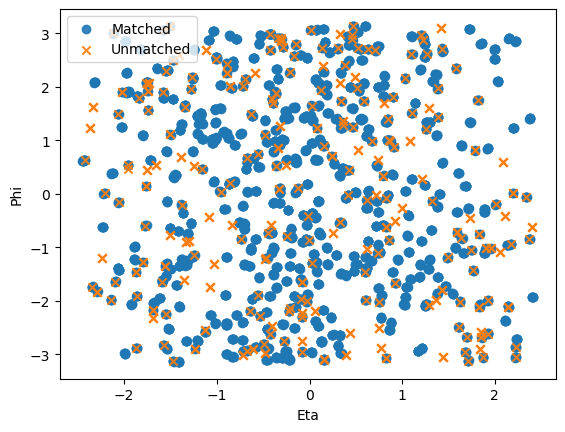

In [11]:
plt.scatter(matched_photons["eta"], matched_photons["phi"], marker="o", alpha=0.9, label="Matched")
plt.scatter(unmatched_photons["eta"], unmatched_photons["phi"], marker="x", alpha=0.9, label="Unmatched")
plt.xlabel("Eta")
plt.ylabel("Phi")
plt.legend()

plt.savefig("truth_plots/unmatched_eta_phi.png")

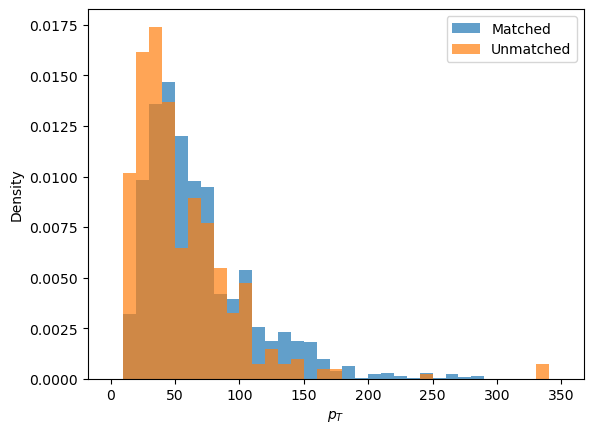

In [13]:
plt.hist(matched_photons["pt"], bins=35, range=(0,350), alpha=0.7, label="Matched", density=True)
plt.hist(unmatched_photons["pt"], bins=35, range=(0,350), alpha=0.7, label="Unmatched", density=True)
plt.xlabel(r"$p_{T}$")
plt.ylabel("Density")
plt.legend()

plt.savefig("truth_plots/unmatched_pt.png")

After applying selection cuts ($\eta <= 2.5, p_{T} > 10.0 GeV$) to the truth photons, we se that ~22% of photons are missed. The Delphes ATLAS card defined photon effiency as 95% for $\eta < 1.5$ and 85% for $1.5 < \eta < 2.5$. Because of this we would expect to see an unmatched photon rate of between 5-15%. (a value we could calcualte more precisely to compare to if observed value was not already outside of this range) However, the observed unmatched rate is ~22%. These plots show that there is no clear $\eta, \phi$ distribution correlation to the unmatched photons. The histogram displaying the $p_{T}$ of matched vs unmatched photons suggests that lower $p_{T}$ photons are more likely to not be reconstructed. This makes physical sense that photons with less energy are less likely to be reconstructed by the detector.